In [1]:
# Necessary imports
import findspark
findspark.init() # Find Spark installation

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType, BooleanType, TimestampType, StructType, StructField

# For ML tasks (even if demonstrating MapReduce concepts, preprocessing often uses MLlib)
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix # For potential matrix operations

import math
import heapq
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *
from src.descriptive_analytics import *
from src.feature_engineering import *

from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql import functions as F

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd
from pyspark.sql.window import Window

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors




In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")


In [3]:
df = preprocess_data(df)

In [4]:
df = preprocess_features(df)

In [5]:
df.printSchema()


root
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = false)
 |-- Start_Lng: double (nullable = false)
 |-- Distance: double (nullable = false)
 |-- State: string (nullable = false)
 |-- Timezone: string (nullable = false)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = false)
 |-- Pressure: double (nullable = false)
 |-- Visibility: double (nullable = false)
 |-- Wind_Speed: double (nullable = false)
 |-- Weather_Condition: string (nullable = false)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- No_Exit: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 

In [6]:
# Step 3: Data Preparation for Classification
# Define categorical, numerical, and boolean columns
categorical_cols = ["State", "Timezone", "Weather_Condition", "Sunrise_Sunset", "Season"]
numerical_cols = [
    "Start_Lat", "Start_Lng", "Distance", "Temperature", "Humidity", 
    "Pressure", "Visibility", "Wind_Speed", "Is_Complex_Road", 
    "Hour", "Day_of_Week", "Month", "Year", "DayOfWeek", "Duration", 
    "Is_Weekend"
]
boolean_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", 
    "No_Exit", "Railway", "Roundabout", "Station", "Stop", 
    "Traffic_Calming", "Traffic_Signal"
]

# Convert boolean columns to integers (0 or 1)
for bool_col in boolean_cols:
    df = df.withColumn(bool_col, col(bool_col).cast("integer"))

# Create stages for the pipeline
stages = []

# StringIndexer and OneHotEncoder for categorical columns
for cat_col in categorical_cols:
    indexer = StringIndexer(
        inputCol=cat_col,
        outputCol=f"{cat_col}_Index",
        handleInvalid="keep"
    )
    encoder = OneHotEncoder(
        inputCols=[f"{cat_col}_Index"],
        outputCols=[f"{cat_col}_OHE"]
    )
    stages += [indexer, encoder]

# Combine numerical, boolean, and encoded categorical columns
feature_cols = numerical_cols + boolean_cols + [f"{cat_col}_OHE" for cat_col in categorical_cols]

# VectorAssembler to combine all features
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)
stages.append(assembler)

# StringIndexer for the target variable (Severity)
label_indexer = StringIndexer(
    inputCol="Severity",
    outputCol="label",
    handleInvalid="keep"
)
stages.append(label_indexer)

# Create and fit the pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
prepared_df = pipeline_model.transform(df)

# Select only the features and label columns for modeling
final_df = prepared_df.select("features", "label")


In [17]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.classification import RandomForestClassifier

# Train a model (using RandomForestClassifier as an example)
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
model = rf.fit(final_df)

# Generate predictions
predictions = model.transform(final_df)

# Evaluation
# Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)
print(f"Precision: {precision}")

# Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall}")

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")


Accuracy: 0.7966703509506979
Precision: 0.6346836480839083
Recall: 0.7966703509506979
F1 Score: 0.7065109609540438


In [18]:
class_metrics = predictions.groupBy("label", "prediction").count().collect()
print("Confusion Matrix:")
for row in class_metrics:
    print(row)

Confusion Matrix:
Row(label=2.0, prediction=0.0, count=204703)
Row(label=1.0, prediction=0.0, count=1299328)
Row(label=0.0, prediction=0.0, count=6156925)
Row(label=3.0, prediction=0.0, count=67366)


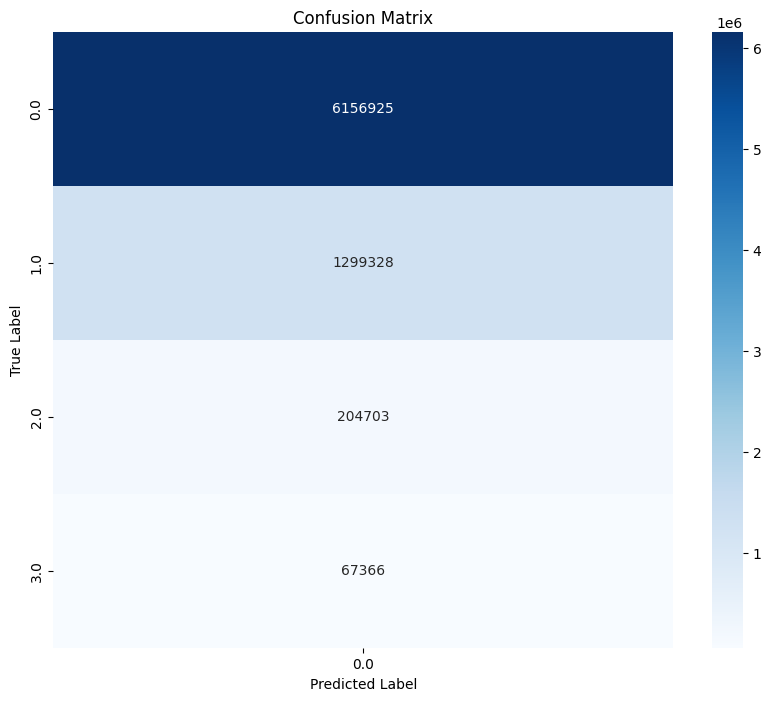

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a trained model and predictions DataFrame
predictions = model.transform(final_df)

# Collecting the predictions and actual values for further analysis
class_metrics = predictions.groupBy("label", "prediction").count().collect()

# Convert to DataFrame
confusion_matrix_data = [{"label": row["label"], "prediction": row["prediction"], "count": row["count"]} for row in class_metrics]
df = pd.DataFrame(confusion_matrix_data)

# Pivot the DataFrame to create the confusion matrix
conf_matrix = df.pivot(index="label", columns="prediction", values="count").fillna(0)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances and convert to list
feature_importances = model.featureImportances.toArray()
print(len(feature_cols),len(feature_importances))
# Ensure the lengths match
if len(feature_cols) == len(feature_importances):
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        "Feature": feature_cols,
        "Importance": feature_importances
    })

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances")
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Error: The lengths of feature_cols and feature_importances do not match.")


33 95
Error: The lengths of feature_cols and feature_importances do not match.
